# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 3.8 MB/s 
     |████████████████████████████████| 376 kB 34.3 MB/s 
     |████████████████████████████████| 58 kB 5.7 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=6132b997786a1c0505d1fc7b26e2987c7e72a28a8e2d50bba12556e815a0a917
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0e3bf50e1586de28eb5249739fbf2e9ab8035172cdd753bbf9cbea1028301125
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-cnviz0jn
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-cnviz0jn
   

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 25.27 MiB/s, done.
Resolving deltas: 100% (3/3), done.


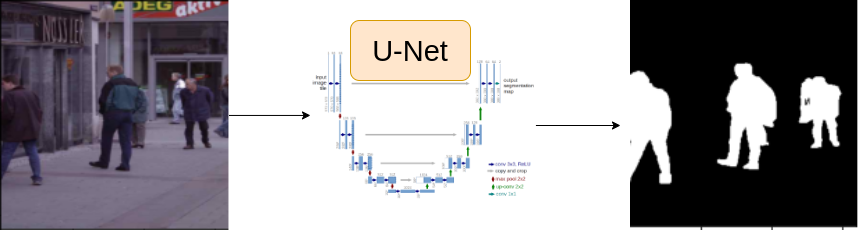

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda' #Por causa da GPU
EPOCHS = 25 
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[3]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

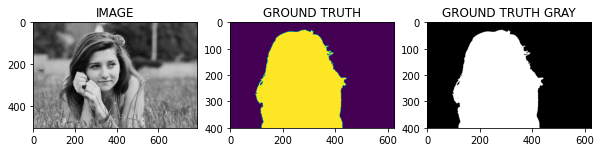

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask)

ax3.set_title('GROUND TRUTH GRAY')
ax3.imshow(mask, cmap='gray')

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
        A.Resize(IMAGE_SIZE,IMAGE_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
        A.Resize(IMAGE_SIZE,IMAGE_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #Shape(h,w,c)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    #Shape(h,w,c) -> (c,h,w)
    #h = 0, c=2, w=1 -> h=1,c=0,w=2
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(test_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [ ]:
idx = 21

image, mask = trainset[idx]

#######VISUALIZARDPS#######

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader = DataLoader(validset,batch_size=BATCH_SIZE)

In [ ]:
print('total de batchs no trainloader', len(trainloader))
print('total de batchs no validloader', len(validloader))

total de batchs no trainloader 15
total de batchs no validloader 4


In [ ]:
for image, mask in trainloader:
  break
  
print(image.shape)
print(mask.shape)

torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights =  WEIGHTS,
        in_channels=3, 
        classes=1,
        activation = None
    )
  
  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images,masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images,masks)
      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss= np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print(f'Epochs: {i+1} , TrainLoss: {train_loss}, ValidLoss {valid_loss}')

100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


SAVED-MODEL
Epochs: 1 , TrainLoss: 0.8056284447511037, ValidLoss 0.5879085063934326


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 2 , TrainLoss: 0.3843133827050527, ValidLoss 0.8727704137563705


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


SAVED-MODEL
Epochs: 3 , TrainLoss: 0.34557271798451744, ValidLoss 0.33792466670274734


100%|██████████| 4/4 [00:01<00:00,  2.07it/s]


SAVED-MODEL
Epochs: 4 , TrainLoss: 0.2631789247194926, ValidLoss 0.23971949517726898


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


Epochs: 5 , TrainLoss: 0.24204482833544413, ValidLoss 0.29305368661880493


100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


SAVED-MODEL
Epochs: 6 , TrainLoss: 0.21478845775127411, ValidLoss 0.23247335106134415


100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


SAVED-MODEL
Epochs: 7 , TrainLoss: 0.16867519716421764, ValidLoss 0.19661226496100426


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


Epochs: 8 , TrainLoss: 0.15803405046463012, ValidLoss 0.2528686225414276


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 9 , TrainLoss: 0.20075411200523377, ValidLoss 0.48677024990320206


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 10 , TrainLoss: 0.20622879266738892, ValidLoss 0.2580150067806244


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epochs: 11 , TrainLoss: 0.18773428350687027, ValidLoss 0.2275616191327572


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epochs: 12 , TrainLoss: 0.14969301372766494, ValidLoss 0.22691166773438454


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Epochs: 13 , TrainLoss: 0.1547921046614647, ValidLoss 0.2509709745645523


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epochs: 14 , TrainLoss: 0.14064892381429672, ValidLoss 0.21066544950008392


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epochs: 15 , TrainLoss: 0.1313704287012418, ValidLoss 0.27238690108060837


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epochs: 16 , TrainLoss: 0.14083659251530964, ValidLoss 0.220188707113266


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epochs: 17 , TrainLoss: 0.13153903782367707, ValidLoss 0.24080481752753258


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Epochs: 18 , TrainLoss: 0.16931872616211574, ValidLoss 0.2654128819704056


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epochs: 19 , TrainLoss: 0.17963689416646958, ValidLoss 0.37597737461328506


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epochs: 20 , TrainLoss: 0.20494408557812374, ValidLoss 0.2487393543124199


100%|██████████| 4/4 [00:01<00:00,  2.78it/s]


Epochs: 21 , TrainLoss: 0.15339617133140565, ValidLoss 0.23516228422522545


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epochs: 22 , TrainLoss: 0.136026298503081, ValidLoss 0.2366882748901844


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epochs: 23 , TrainLoss: 0.13306636611620584, ValidLoss 0.19711210951209068


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


SAVED-MODEL
Epochs: 24 , TrainLoss: 0.1113343079884847, ValidLoss 0.1873496137559414


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

Epochs: 25 , TrainLoss: 0.1053749625881513, ValidLoss 0.2412802241742611


# Task 9 : Inference

In [ ]:
idx = 5

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0)) #C,H,W -> #1, C,H,W

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

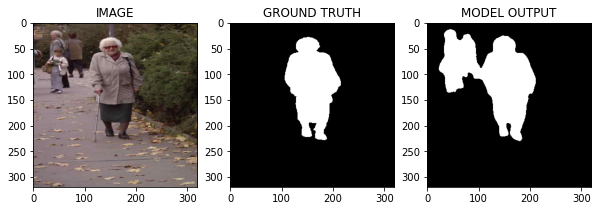

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))